## 4.2-Web services: Deploying models with Flask and Docker

1. Creating a virtual environment with Pipenv;
2. Creating a script for predicting;
3. Putting the script into a Flask app;
4. Packaging the app to Docker

### 1. Creating a virtual environment with VirtualEnv

**Create a virtual environment** using **python3.9**

In [3]:
! which python

/home/fdelca/.virtualenvs/mlcourse04/bin/python


In [6]:
! python --version

Python 3.9.13


**Install the right version of sklearn**

We should get the exact same version as we used when we were building the model.

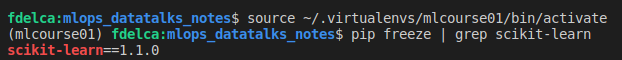

In [4]:
! pip install scikit-learn==1.1.0

**And we also need to install flask in our environment**

In [5]:
! pip install flask

**Also we need to install requests**

Only for development/test

In [5]:
! pip install requests

**Write the packages installed in a requirements.txt file**

In [6]:
! pip freeze > requirements.txt

In [7]:
! cat requirements.txt

argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.0.5
attrs==21.4.0
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==5.0.0
certifi==2022.5.18.1
cffi==1.15.0
charset-normalizer==2.0.12
click==8.1.3
debugpy==1.6.0
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
executing==0.8.3
fastjsonschema==2.15.3
Flask==2.1.2
idna==3.3
importlib-metadata==4.11.4
ipykernel==6.14.0
ipython==8.4.0
ipython-genutils==0.2.0
itsdangerous==2.1.2
jedi==0.18.1
Jinja2==3.1.2
joblib==1.1.0
jsonschema==4.6.0
jupyter-client==7.3.4
jupyter-core==4.10.0
jupyterlab-pygments==0.2.2
MarkupSafe==2.1.1
matplotlib-inline==0.1.3
mistune==0.8.4
nbclient==0.6.4
nbconvert==6.5.0
nbformat==5.4.0
nest-asyncio==1.5.5
notebook==6.4.12
numpy==1.22.4
packaging==21.3
pandocfilters==1.5.0
parso==0.8.3
pexpect==4.8.0
pickleshare==0.7.5
prometheus-client==0.14.1
prompt-toolkit==3.0.29
psutil==5.9.1
ptyprocess==0.7.0
pure-eval==0.2.2
pycparser==2.21
Pygments==2.12.0
pyparsing==3.0.9
pyrsistent==0.18.1
python-dateutil==2.8.

### 2. Creating a prediction.py script

That will:
- Load the model;
- Score the request;
- Return the score

2.1 **Move the model created to the same folder as the script**

2.2 **Build a predict.py script**

```python
import pickle 

# Load the model
with open('lin_reg.bin', 'rb') as f_in:
    (dv, model) = pickle.load(f_in)


# Data Transformation
def prepare_features(ride):
    features = {}
    features['PU_DO'] = '%s_%s' % (ride['PULocationID'],ride['DOLocationID']) # This approach will turn everything into a string
    features['trip_distance'] = ride['trip_distance']
    return features


# Create a function to predict
def predict(features):
    X = dv.transform(features)
    preds = model.predict(X)
    return preds
```

2.3 **Build a test.py script**

```python
import predict

ride = {
    "PULocationID": 10,
    "DOLocationID": 50,
    "trip_distance": 40, 
}


features = predict.prepare_features(ride)
pred = predict.predict(features)
print(pred)
```

In [3]:
! python test.py

25.82088229285187


It works! Now lets wrap up everything in a Flask application

### 3. Putting the script into a Flask app;

```python
import pickle 
from flask import Flask, request, jsonify

# Load the model
with open('lin_reg.bin', 'rb') as f_in:
    (dv, model) = pickle.load(f_in)


# Data Transformation
def prepare_features(ride):
    features = {}
    features['PU_DO'] = '%s_%s' % (ride['PULocationID'], ride['DOLocationID']) # This approach will turn everything into a string
    features['trip_distance'] = ride['trip_distance']
    return features


# Create a function to predict
def predict(features):
    X = dv.transform(features)
    preds = model.predict(X)
    return float(preds[0])



# Create a flask application
app = Flask('duration-prediction')


# Create a function to wrap everything
@app.route('/predict', methods=['POST'])
def predict_endpoint():
    ride = request.get_json()

    features = prepare_features(ride)
    pred = predict(features)

    result = {
        'duration': pred
    }

    return jsonify(result)


# And finally run the flask application
if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=9696)
```

3.1 **Then run `! python predict.py` to run the app**

3.2 **Now we can try to make a request**

For that we will change the `test.py` file and run it

```python
import requests

ride = {
    "PULocationID": 10,
    "DOLocationID": 50,
    "trip_distance": 40, 
}

url = 'http://127.0.0.1:9696/predict'
response = requests.post(url, json=ride)
print(response.json())
```

In [9]:
! python test.py

{'duration': 25.82088229285187}


3.3 **Install gunicorn to avoid the warning below:**

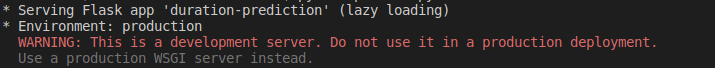

In [10]:
! pip install gunicorn

  Using cached gunicorn-20.1.0-py3-none-any.whl (79 kB)


In [11]:
! pip freeze > requirements.txt

3.4 **Then run it using gunicorn**

`! gunicorn --bind=0.0.0.0:9696 predict:app` - Go to predict module (predict.py) and look for `app`

In [12]:
! python test.py

{'duration': 25.82088229285187}


3.5 **Install --dev requests instead of just request for production purposes** (Only when using Pipenv)

`! pip install --dev requests`

### 4. Packaging the app to Docker

In [14]:
! python --version

Python 3.9.13


4.1 **Create a Dockerfile**

```docker
FROM python:3.9.13-slim

RUN pip install -U pip

WORKDIR /app

COPY ["requirements.txt", "./"]

RUN pip install -r requirements.txt

COPY ["predict.py", "lin_reg.bin", "./"]

EXPOSE 9696

ENTRYPOINT [ "gunicorn" , "--bind=0.0.0.0:9696", "predict:app"]
```

4.2 **Build the docker container created**

This docker file will create an image:
```bash
docker build -t ride-duration-prediction-service:v1 .
```

To run it:
```bash
docker run -it --rm -p 9696:9696  ride-duration-prediction-service:v1
```

In [15]:
! python test.py

{'duration': 25.82088229285187}
